# Final Project Submission

Please fill out:
* **Student name:** Milad Shirani
* **Student pace:** self paced
* **Scheduled project review date/time:** 
* **Instructor name:** Claude Fried
* **Blog post URL:**


# Importing Data

In [302]:
# Your code here - remember to use markdown cells for comments as well!

import os
import numpy as np
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

data_initial = pd.read_csv("./data/kc_house_data.csv")

# to_drop = ["date", "view", "sqft_above" ,"sqft_basement", "yr_renovated", 
#            "zipcode", "lat", "long", "sqft_living15", "sqft_lot15", "id"]

to_drop_initial = ["date", "view", "sqft_above" ,"sqft_basement", "yr_renovated", 
           "sqft_living15", "sqft_lot15", "id"]

# to_drop = ["date", "view", "sqft_basement", "yr_renovated", 
#            "sqft_living15", "sqft_lot15", "id"]


df = data_initial.drop(columns = to_drop_initial, axis = 1)

# Functions we use to convert data and calculate correlation coefficients

In [303]:
def corr(data, value):
    corr_table = data.corr().abs().stack().reset_index().sort_values(0, 
                                                            ascending=False)
    
    corr_table["pairs"]=list(zip(corr_table["level_1"],corr_table["level_0"]))
    
    corr_table.drop(columns = ["level_1", "level_0"], inplace = True)
    corr_table.reset_index(inplace = True, drop = True)


    corr_1 = corr_table.iloc[0:len(data.columns)].index
    corr_table.drop(index = corr_1, inplace = True)
    corr_table.reset_index(inplace = True, drop = True)
    table1 = corr_table.iloc[range(0, len(corr_table), 2)]
    table = table1.loc[table1[0]>value]
    table.reset_index(inplace = True, drop = True)
    
    
    return table

In [304]:
def convert(data):
    
    
    d_log = np.log(data)
    d_log_mean = np.mean(d_log)
    d_log_max = max(d_log.astype("float"))
    d_log_min = min(d_log.astype("float"))
    
    d_convert = (d_log - d_log_mean) / (d_log_max - d_log_min)
    
    
    return d_convert

# Categorical and Numerical Values

In [305]:
y = df["price"]
numerical  = df.drop(columns = ["price", "zipcode"], axis = 1).select_dtypes(
    include=["float64", "int64"])
l = list(numerical.columns)
l.append("price")
categorical = df.drop(columns = l, axis = 1)


print("numerical variables:\n", list(numerical.columns))
print("\n")
print("categorical variables:\n", list(categorical.columns))

numerical variables:
 ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_built', 'lat', 'long']


categorical variables:
 ['waterfront', 'condition', 'grade', 'zipcode']


# Some Insight Into Data

## Scatter Plots for Categorical Features

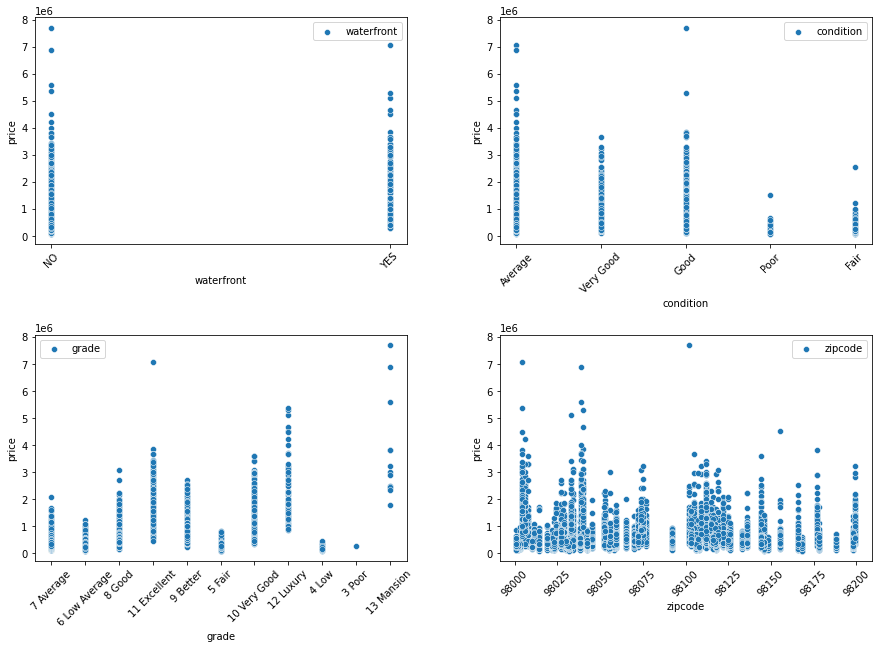

In [306]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

to_pick = list(categorical.columns)

for i,col in enumerate(to_pick):
    ax = axes[i//2][i%2]
    sns.scatterplot(x = df[col], y = df["price"], ax = ax, label = col)
    ax.tick_params(axis='x', labelrotation = 45)
    

## Scatter Plots for Numerical data

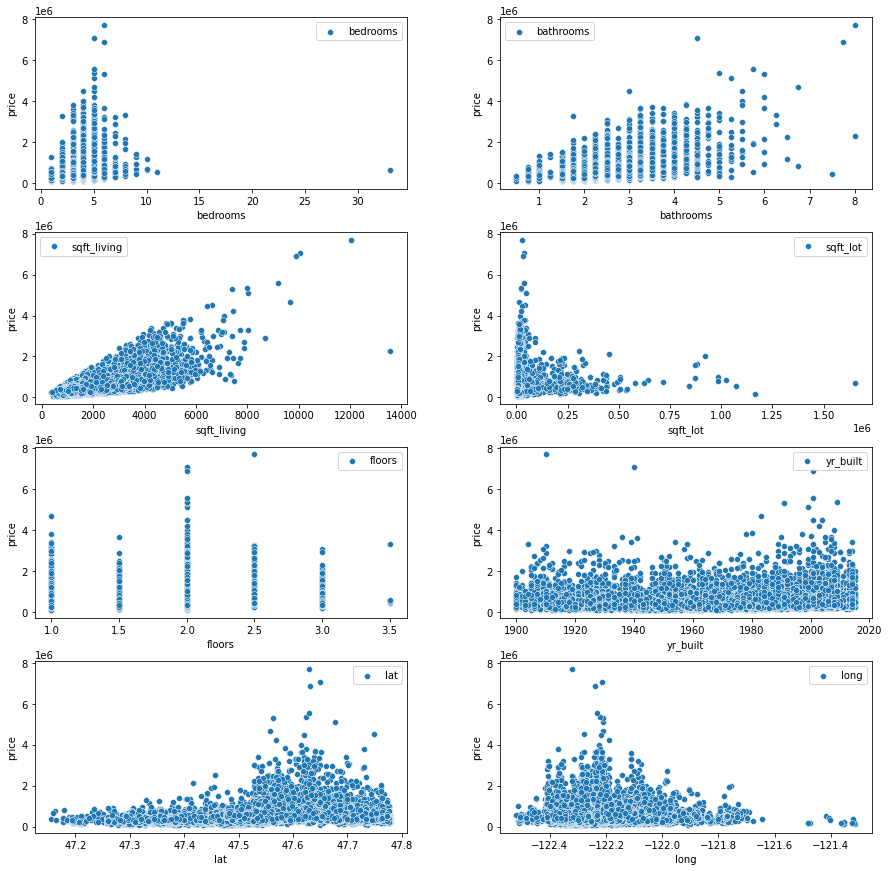

In [307]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15,15))
fig.subplots_adjust(hspace=0.25, wspace=0.25)

to_pick = list(numerical.columns)

for i,col in enumerate(to_pick):
    ax = axes[i//2][i%2]
    sns.scatterplot(x = df[col], y = df["price"], ax = ax, label = col)
    

As we can see there is an outlier in the total number of bedrooms. So we are going to drop that first

In [308]:
ind = df.loc[df["bedrooms"] > 30].index
ind_numerical = numerical.loc[numerical["bedrooms"] > 30].index

df.drop(index = ind, inplace = True)
numerical.drop(index = ind_numerical, inplace = True)

Now we are going to convert (scaling and normalizing) the data in the columns `price`, `lat`, `long`, `yr_built`, `sqft_living` and `sqft_lot` to make the data more normal. However, if we check we realize that the values of the column `long` are all negative and we need to first multiply them with a minus sign to be able to convert them by a logarithmic function. 

In [309]:
sum(df["long"] > 0)
df["long"] = -1 * df["long"]
to_convert = ['sqft_living', 'sqft_lot', "price", "yr_built", "long", "lat"] 
for item in to_convert:
    if item == "price":
        df[item] = convert(df[item])
    else:
        df[item] = convert(df[item])
        numerical[item] = convert(numerical[item])

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


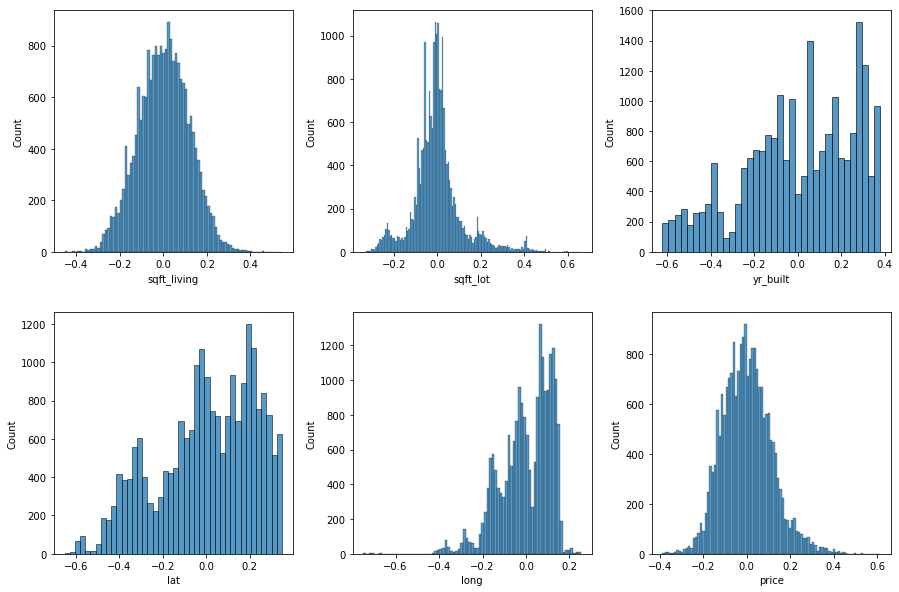

In [310]:
r = 2
c = 3
fig, axes = plt.subplots(nrows = r, ncols = c, figsize = (15,10))
fig.subplots_adjust(hspace=0.25, wspace=0.25)

to_pick = list(numerical.columns)

to_pick.remove("bedrooms")
to_pick.remove("bathrooms")
to_pick.remove("floors")
for i,col in enumerate(to_pick):
    ax = axes[i//3][i%3]
    sns.histplot(x = df[col],ax = ax, label = col)
ax = axes[r-1][c-1]
sns.histplot(x = df["price"],ax = ax, label = col);

# Categorical

First let's check the null values of categorical variable.

In [311]:
a = categorical.isna().sum().to_frame().reset_index()

It seems that `{{a.iloc[0,0]}}` has the total number of `{{a.iloc[0,1]}}` missing values.


## Creating New Column For Missing Values

We know that the column `{{a.iloc[0,0]}}` has `{{a.iloc[0,1]}}` missing values. Therefore, we are going to create a column called `{{a.iloc[0,0]}}_null` to indicate where data is missing. In order to do so, we take the following steps:

1. First we use `MissingIndicator` from `sklearn.impute` to create a column in `df` called `{{a.iloc[0,0]}}_null`. 

```python
from sklearn.impute import MissingIndicator
```

2. then we are going to impute the missing values in the column `{{a.iloc[0,0]}}` by using `SimpleImputer` from `sklearn.impute`. 

```python
from sklearn.impute import SimpleImputer
```

3. At the end, we will use `OrdinalEncoder` from `from sklearn.preprocessing` to convert the binary values into numerical values.

```python
from sklearn.preprocessing import OrdinalEncoder
```

### Missing Indicator for `waterfront`

In [313]:
from sklearn.impute import MissingIndicator
missing_indicator = MissingIndicator()

null_val = df[["waterfront"]]
missing_indicator.fit(null_val)
df["waterfront_null"] = missing_indicator.transform(null_val)

### Imputing Missing Values for `waterfront`

In [314]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[["waterfront"]])
df["waterfront_impute"] = imputer.transform(df[["waterfront"]])

### Convert Categorical `waterfront` into Numbers

#### Converting the Column `waterfront_impute` to numerical value

In [315]:
from sklearn.preprocessing import OrdinalEncoder

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(df[["waterfront_impute"]])

# encoder_waterfront.categories_[0]
encoder_waterfront_transform = encoder_waterfront.transform(
    df[["waterfront_impute"]]).flatten()
# encoder_waterfront_transform

df["waterfront_impute"] = encoder_waterfront_transform

df.drop(columns = ['waterfront'], inplace = True, axis = 1)



#### Converting the Column `waterfront_null` to Numerical value

In [316]:
from sklearn.preprocessing import OrdinalEncoder

encoder_waterfront_null = OrdinalEncoder()
encoder_waterfront_null.fit(df[["waterfront_null"]])

# encoder_waterfront_null.categories_[0]

encoder_waterfront_null_transform = encoder_waterfront_null.transform(
    df[["waterfront_null"]]).flatten()

df["waterfront_null"] = encoder_waterfront_null_transform


## Converting `condition`, `grade` and `zipcode` to numerical values

In order to convert categorical values with multiple values we should use `OneHotEncoder` from `sklearn.preprocessing`. We have two columns `condition` and `grade` with the following values

1. `condition`

`{{categorical["condition"].value_counts()}}`

2. `grade`

`{{categorical["grade"].value_counts()}}`

3. `zipcode`

`{{categorical["zipcode"].value_counts()}}`

### Converting `condition` to numerical values

In [317]:
from sklearn.preprocessing import OneHotEncoder

condition_cat = df[["condition"]]

ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(condition_cat)
# ohe.categories_
condition_num = ohe.transform(condition_cat)
condition_num_df = pd.DataFrame(condition_num, 
                               columns = ohe.categories_[0],
                               index = df.index)
df.drop(columns = ["condition"], inplace = True, axis = 1)

### Converting `grade` to numerical values

In [318]:
from sklearn.preprocessing import OneHotEncoder

grade_cat = df[["grade"]]

ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(grade_cat)
# ohe.categories_
grade_num = ohe.transform(grade_cat)
grade_num_df = pd.DataFrame(grade_num, 
                           columns = ohe.categories_[0],
                           index = df.index)
df.drop(columns = ["grade"], inplace = True, axis = 1)

### Converting `zipcode` to numerical values

In [319]:
from sklearn.preprocessing import OneHotEncoder

zipcode_cat = df[["zipcode"]]

ohe = OneHotEncoder(categories='auto', sparse=False, drop= "first")
ohe.fit(zipcode_cat)
zipcode_num = ohe.transform(zipcode_cat)

zipcode_num_df = pd.DataFrame(zipcode_num, 
                           columns = ohe.categories_[0][1:],
                           index = df.index)


# concatenate different dataframes 

In [320]:
def concatenate(data, 
               sub_df1,
               sub_df2,
               sub_df3,   
               include_sub_df1 = False,     
               include_sub_df2 = False,
               include_sub_df3 = False
                ):
    
    
    if (include_sub_df1 == True 
        and include_sub_df2 == False 
        and include_sub_df3 == False):
        
        df_final = pd.concat([data, sub_df1], axis = 1)
        
    elif (include_sub_df1 == False 
        and include_sub_df2 == True 
        and include_sub_df3 == False):
        
        df_final = pd.concat([data, sub_df2], axis = 1)
        
    elif (include_sub_df1 == False 
        and include_sub_df2 == False 
        and include_sub_df3 == True):
        
        df_final = pd.concat([data, sub_df3], axis = 1)    
        
    elif include_sub_df1 == True and include_sub_df2 == True:
        
        df_final = pd.concat([data, sub_df1, sub_df2], axis = 1)
        
    elif include_sub_df1 == True and include_sub_df3 == True: 
        
        df_final = pd.concat([data, sub_df1, dub_df3], axis = 1)
        
    elif include_sub_df2 == True and include_sub_df3 == True: 
        
        df_final = pd.concat([data, sub_df2, dub_df3], axis = 1)
        
    else:
        
        df_final = pd.concat([data, sub_df1, sub_df2, dub_df3], axis = 1)
        
    return df_final

In [321]:
# df_final = pd.concat([df, grade_num_df, condition_num_df, zipcode_num_df]
# , axis = 1)
# df_final = pd.concat([df, condition_num_df, zipcode_num_df], axis = 1)
# df_final = pd.concat([df, grade_num_df, bed_num_df], axis = 1)
# df_final = pd.concat([df, grade_num_df, zipcode_num_df], axis = 1)

# df_final = pd.concat([df, grade_num_df], axis = 1)
# df_final = df
df_final = concatenate(
               data = df ,
               sub_df1 = grade_num_df, 
               sub_df2 = zipcode_num_df, 
               sub_df3 = condition_num_df,    
               include_sub_df1 = True,     
               include_sub_df2 = False,
               include_sub_df3 = False
                     )

In [322]:
table = corr(data = df_final, value = 0.5)
print(table)

          0                     pairs
0  0.762133  (bathrooms, sqft_living)
1  0.674820      (price, sqft_living)
2  0.637670   (sqft_living, bedrooms)
3  0.564021           (long, zipcode)
4  0.551270        (price, bathrooms)
5  0.527870     (bathrooms, bedrooms)
6  0.526870       (7 Average, 8 Good)
7  0.505593     (bathrooms, yr_built)
8  0.502574       (bathrooms, floors)


In [323]:
import statsmodels.api as sm
## For Grade use the following Drop

to_drop = ["price" # ,"13 Mansion" , "12 Luxury" 
          # , "4 Low"
          , "10 Very Good"
          , "11 Excellent"
          , "3 Poor"
          , "9 Better"
          , "long" 
          , "zipcode"
          # , "waterfront_impute"
          , "waterfront_null" 
          , "sqft_lot"
          , "bedrooms", "floors", "bathrooms"
          ]

## For Condition use the following Drop
# to_drop = ["price"]

features = df_final.drop(columns = to_drop, axis = 1)
X = sm.add_constant(features)
model = sm.OLS(df_final["price"], X)
results = model.fit()
results_summary = results.summary()
print(results_summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     5403.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        01:41:00   Log-Likelihood:                 30412.
No. Observations:               21596   AIC:                        -6.080e+04
Df Residuals:                   21584   BIC:                        -6.070e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0788      0.00

In order to update the text automatically, we are going to convert `results_summary` into `Pandas DataFrame` to find `R2-scores`, `coefficients` and `P-values` for different models.  

In [324]:
def results_summary(data, to_drop):
    import statsmodels.api as sm
    
    features = df_final.drop(columns = to_drop, axis = 1)
    X = sm.add_constant(features)
    model = sm.OLS(df_final["price"], X)
    results = model.fit()
    results_summary = results.summary()
    
    ### Converting results_summary to pandas dataframe
    results_R2 = results_summary.tables[0].as_html()
    R2_df = pd.read_html(results_R2, header=0, index_col=0)[0]
    R2_df.reset_index(inplace = True)
    R2_df = R2_df.columns.to_frame().T.append(R2_df, ignore_index=True)
    R2_df.columns = range(len(R2_df.columns))
    
    

    results_coeff = results_summary.tables[1].as_html()
    coeff_df = pd.read_html(results_coeff, header=0, index_col=0)[0]
    coeff_df.reset_index(inplace = True)
    coeff_df = coeff_df.columns.to_frame().T.append(coeff_df, 
                                                    ignore_index=True)
    coeff_df.columns = range(len(coeff_df.columns))



    results_collin = results_summary.tables[2].as_html()
    collin_df = pd.read_html(results_collin, header=0, index_col=0)[0]
    collin_df.reset_index(inplace = True)
    collin_df = collin_df.columns.to_frame().T.append(collin_df, 
                                                      ignore_index=True)
    collin_df.columns = range(len(collin_df.columns))
    
    
    R2 = R2_df.iloc[0, 3]

    collinearity_num = collin_df.iloc[3, 3]

    coefficients_name_value = coeff_df.iloc[1:,[0,1]]

    coefficients_name_pval = coeff_df.iloc[1:,[0,4]]
    
    return R2, collinearity_num, coefficients_name_value, coefficients_name_pval

In [325]:
R2,_,_,_ = results_summary(data = df_final, to_drop = to_drop)
_ ,cl,_,_ = results_summary(data = df_final, to_drop = to_drop)
print("R2        : ", R2)
print("Cond. No. : ", cl)

R2        :  0.734
Cond. No. :  46.4


# Baseline Model

In [327]:
from sklearn.model_selection import train_test_split

X = df_final.drop(columns = to_drop, axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [328]:
numerical = df.drop(columns = ["price"], axis = 1).select_dtypes(
    include=["float64", "int64"])
corr_column = list(numerical.columns)
corr_dict = {}
for item in corr_column:
    corr_dict[df["price"].corr(df[item])] = item
high_corr = corr_dict[max(corr_dict)]
high_corr

'sqft_living'

In [329]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

baseline_model = LinearRegression()

splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[[high_corr]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.45509117441817726
Validation score: 0.45976780391206784


# Building Second Model


In [330]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

second_model = LinearRegression()



splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

secondmodel_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:      ", secondmodel_scores["train_score"])
print("Validation score: ", secondmodel_scores["test_score"])

print()

print("Train score(mean):      ", secondmodel_scores["train_score"].mean())
print("Validation score(mean): ", secondmodel_scores["test_score"].mean())

print()

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())




Train score:       [0.73792844 0.73290809 0.73558731 0.73534588 0.73546366]
Validation score:  [0.72891297 0.74327379 0.73560546 0.73619056 0.73581502]

Train score(mean):       0.7354466758772282
Validation score(mean):  0.7359595605541541

Train score:      0.45509117441817726
Validation score: 0.45976780391206784


# Train-Test splits


In [331]:
from sklearn.model_selection import train_test_split

X = df_final.drop(columns = to_drop, axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [332]:
from sklearn.linear_model import LinearRegression

final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)
prediction = final_model.predict(X_test)


In [333]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, final_model.predict(X_test), squared=False)

0.059795502996915724

# Assumption Checking

## Checking Normality of residuals

We will check if the residuals are normal buy checking the Q-Q Plot for the residuals.

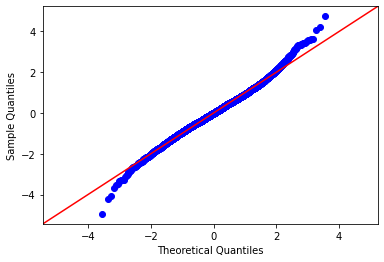

In [334]:
import scipy.stats as stats

residuals = (y_test - prediction)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Investigating Multicollinearity (Independence Assumption)


In [335]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [
    variance_inflation_factor(X_train.values, i) 
    for i in 
       range(X_train.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=X_train.columns,
                              name="Variance Inflation Factor")
variance_inf_fact

const                8.774125
sqft_living          2.163269
yr_built             1.381739
lat                  1.076639
waterfront_impute    1.017247
12 Luxury            1.036329
13 Mansion           1.006410
4 Low                1.040826
5 Fair               1.319475
6 Low Average        2.719527
7 Average            3.386316
8 Good               2.193616
Name: Variance Inflation Factor, dtype: float64

### Investigating Homoscedasticity

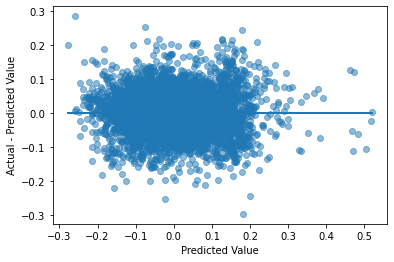

In [336]:
fig, ax = plt.subplots()

ax.scatter(prediction, residuals, alpha=0.5)
ax.plot(prediction, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

###  Investigating Linearity

-0.3748911534861146 0.5926832350331576


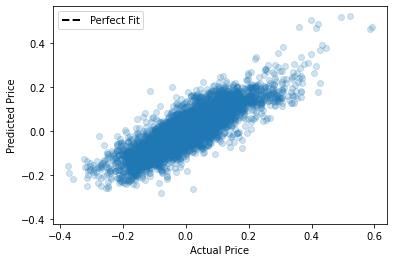

In [337]:
prediction = final_model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="black", label="Perfect Fit",
       lw = 2)
ax.scatter(y_test, prediction, alpha=0.2)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();
print(y_test.min(), y_test.max())

# Model's Shortcomings

# Business Suggestion